# Skyrmion oscillations by spin currents

## Action plan
1. For this I have to define material parameters to the point where skyrmions are naturally stable.
2. Set the disk geometry of the simulation cell.
3. Set the spin current.
4. Run the simulation.
5. Export an image of the system.
6. FFT the result to find the oscillation frequency.
7. Process the FFT to find peaks.
8. Make a set of values for the spin current, and run the simulation for each spin current.
9. Plot the FFT frequency peak against the current.
10. Determine whether the behavior is linear or not.

## Processing helper functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
import os
import shutil
import re
import subprocess
import glob

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)

    
    return fields

def run_mumax3(script, name, verbose=False, interactive=False):
    """Executes a mumax3 script and converts ovf files to numpy files.
    
    Parameters
    ----------
    script: string containing the mumax3 input script
    name: name of the simulation (this will be the name of the script and output dir)
    verbose: print stdout of mumax3 when it is finished
    interactive: boolean to decide whether to run mumax3 with the user interface
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir = name + ".out"

    # Write the input script in scriptfile
    with open(scriptfile, 'w') as f:
        f.write(script)
    
    # Prepare the command based on the interactive parameter
    command = ["mumax3", "-f"]
    if interactive:
        command.append("-i")
    command.append(scriptfile)
    
    # Call mumax3 to execute the script
    p = run(command, stdout=PIPE, stderr=STDOUT)
    
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    # Assuming functions read_mumax3_table and read_mumax3_ovffiles are defined elsewhere
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
    
    return table

def identify_peaks_and_plot(dm, dt, fmax, min_freq_threshold=0.5e9, ja_value = 3.0, min_height=0):
    """
    Identifies the first three significant peaks in the FFT of the provided data.

    Parameters:
    - dm: Pandas Series or numpy array of the average magnetization deviation.
    - dt: Sampling time interval.
    - fmax: Maximum frequency to display in the plot.
    - min_freq_threshold: Minimum frequency threshold to exclude the zero-frequency peak.

    Returns:
    - fig: Matplotlib figure object containing the plot.
    - peak_freqs: Frequencies of the first three significant peaks found.
    """
    
    spectr = np.abs(np.fft.fft(dm))    # the absolute value of the FFT of dm
    freq = np.fft.fftfreq(len(dm), d=dt)  # the frequencies for this FFT
    
    # Only consider the positive half of the frequencies (ignoring the negative frequencies)
    positive_freqs = freq[:len(freq)//2]
    positive_spectr = spectr[:len(spectr)//2]
    
    # FIND PEAKS - Using 'find_peaks' from scipy.signal, excluding the peak near zero by threshold
    peaks, properties = find_peaks(positive_spectr, height=min_height)
    peaks_above_threshold = peaks[positive_freqs[peaks] > min_freq_threshold]
    
    # Sort the peaks based on their frequency, get the first three peaks above the threshold
    lowest_freq_peaks = peaks_above_threshold[np.argsort(positive_freqs[peaks_above_threshold])][:3]
    plot_x_render_limit = positive_freqs[lowest_freq_peaks[0]] + positive_freqs[lowest_freq_peaks[-1]]

    # CREATE PLOT
    fig, ax = plt.subplots(figsize=(10, 6))  # Optional: Adjust figure size
    ax.plot(positive_freqs/1e9, positive_spectr, label='FFT Spectrum')
    ax.set_xlim(0, plot_x_render_limit/1e9)
    ax.set_ylabel("Spectrum (Arbitrary Units)")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_title(f"Frequency Spectrum of Magnetization Deviation - ja = {ja_value}")
    
    # Highlight and label the first 3 identified peaks above the threshold
    for peak in lowest_freq_peaks:
        peak_freq = positive_freqs[peak]
        ax.axvline(x=peak_freq/1e9, color='r', linestyle='--', label=f'Peak at {peak_freq/1e9:.3f} GHz')
    
    # Avoid duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())
    
    ax.grid(True)  # Optional: Adds grid for better readability
    
    # Extract the frequencies of the first three significant peaks
    peak_freqs = positive_freqs[lowest_freq_peaks]/1e9
    
    return fig, peak_freqs

def create_incremented_dir(base_dir):
    """
    Checks for existing directories with a number at the end, and creates a new directory
    with the next available number incremented by one from the largest one existent.
    
    Parameters:
    - base_dir: The base name of the directory without the number.
    
    Returns:
    - new_dir_path: The path to the newly created directory.
    - dir_number: The number assigned to the new directory.
    """
    # Regular expression to match the pattern of the directories
    dir_pattern = re.compile(r'^' + re.escape(base_dir) + r'(\d+)$')
    
    # Get all items in the current directory
    items = os.listdir()
    
    # Filter items that match the pattern and extract numbers
    numbers = [int(match.group(1)) for item in items if (match := dir_pattern.match(item))]
    
    # Determine the next directory number
    dir_number = max(numbers) + 1 if numbers else 1
    
    # Form the new directory path
    new_dir_path = f"{base_dir}{dir_number}"
    
    # Create the new directory
    os.makedirs(new_dir_path, exist_ok=True)
    
    return new_dir_path, dir_number

def convert_ovf_to_jpg(input_dir, output_dir):
    # Find all .ovf files in the input directory
    ovf_files = glob.glob(os.path.join(input_dir, '*.ovf'))
    
    # Iterate over each .ovf file and execute the conversion command
    for ovf_file in ovf_files:
        # Define the output filename with .jpg extension
        output_filename = os.path.basename(ovf_file).replace('.ovf', '.jpg')
        
        # Execute the mumax3-convert command
        subprocess.run(['mumax3-convert', '-jpg', '-o', output_dir, ovf_file])

def delete_path(path_to_delete, extension=None):
    if os.path.isfile(path_to_delete):
        os.remove(path_to_delete)  # Removes a file.
    elif os.path.isdir(path_to_delete) and extension is None:
        shutil.rmtree(path_to_delete)  # Removes a directory and all its contents.
    elif os.path.isdir(path_to_delete) and extension is not None:
        # Delete all files with the specified extension in the directory
        files_to_delete = glob.glob(os.path.join(path_to_delete, f'*{extension}'))
        for file in files_to_delete:
            os.remove(file)
    else:
        print(f"The path {path_to_delete} is invalid or does not exist.")

## Mumax3 Script generator

In [4]:
default_fmax = 200e9
default_dt = 1/(2*default_fmax)
default_T = 2e-9
def generate_skyrmion_breathing_script(fmax = default_fmax, T = default_T, ja = 3e12):

    # NUMERICAL PARAMETERS RELEVANT FOR THE SPECTRUM ANALYSIS
    fmax # maximum frequency (in Hz) of the sinc pulse
    T    # simulation time (longer -> better frequency resolution)
    dt   = 1/(2*fmax)  # the sample time (Nyquist theorem taken into account)
    ja   # the spin current - A/m2
    default_fmax = fmax
    default_dt = dt
    default_T = T

    script=f"""
    // geometry
    sizeX := 200e-9
    sizeY := 200e-9
    sizeZ :=1e-9

    // inner circle for injecting current

    sizeX2 := 50e-9
    sizey2 := 50e-9

    Nx := 192
    Ny := 192
    Nz := 1
    
    setgridsize(Nx, Ny, Nz)
    setcellsize(sizeX/Nx, sizeY/Ny, sizeZ/Nz)
    setGeom(ellipse(sizeX, sizeY))

    defRegion(1,circle(sizeX2))


    // set up free layer
    Msat = 580e+3    // A/m
    Aex= 1.5e-11     // exchange stiffness Fe
    alpha = 0.3

    //m = uniform(0, 0, 1)

    Dind_ini :=3e-3   // J/m2   calculated ab-initio Au/Fe/MgO
    Ku1_ini := 0.8e+6 // J/m3   calculated ab-initio Au/Fe/MgO

    Dind = Dind_ini
    Ku1 =Ku1_ini
    AnisU = vector(0,0,1)

    m = NeelSkyrmion(1,-1).scale(3,3,1)

    minimize()

    V:=0.0
    Dind_red:=Dind_ini*(1-V)
    Ku1_red:= Ku1_ini*(1-V)
    AnisU = vector(0,0,1)

    // set up fixed and spacer layer parameters
    lambda = 1
    Pol= 0.8
    epsilonprime = 0
    xi=0.2

    // set up fixed layer polarization

    fixedlayer = vector(0, 0, 1)


    //Temp=300.00

    ja:={ja}			// A/m2
    J.setRegion(1,vector(0,0,-ja)) 	// A/m2

    Dind = Dind_ini
    Ku1 = Ku1_ini

    Dind.setRegion(1, Dind_red)
    Ku1.setRegion(1, Ku1_red)

    Ba:=0.1
    B_ext=vector(0.0,0.0,Ba)

    tableadd(E_total)
    tableadd(maxangle)
    autosave(m, {dt})
    tableautosave({dt})
    run({T})
    """

    return script

## Run the script below to process the end-to-end study

In [6]:
iteration_dir = 'run_files'

iteration_dir, dir_number = create_incremented_dir(iteration_dir)
min_fft_peak_height = 20
should_delete_ovf_files = False

# Writing to files
ja_values = np.arange(3e12, 3.5e12, 0.5e12)
for i, ja in enumerate(ja_values):
    output_dir = f"{iteration_dir}{os.path.sep}oscillating_Skyrmion_ja={ja/1e12}e12"
    table = run_mumax3(
        generate_skyrmion_breathing_script(ja=ja),
        name=output_dir,
        verbose=False,
        interactive=False)
    
    # Save table and fields to disk
    npy_dir = f"{iteration_dir}{os.path.sep}npy_arrays"
    os.makedirs(npy_dir, exist_ok=True)
    np.save(os.path.join(npy_dir, f"table_{i}.npy"), table)

    # Save images for each run
    images_dir = f"{output_dir}.out{os.path.sep}images"
    os.makedirs(images_dir, exist_ok=True)
    convert_ovf_to_jpg(f"{output_dir}.out", images_dir)

    # Convert images to video and delete originals
    subprocess.run([
    'ffmpeg', '-r', '30', '-pattern_type', 'glob', '-i', f'{images_dir}{os.path.sep}*.jpg',
    '-c:v', 'libvpx-vp9', '-pix_fmt', 'yuv420p', '-crf', '30', '-b:v', '0',
    '-preset', 'veryfast', f'{iteration_dir}{os.path.sep}ja={ja/1e12}e12.webm'
    ])
    delete_path(images_dir)

    # Delete large files if requested
    if should_delete_ovf_files:
        delete_path(f"{output_dir}.out", extension='.ovf')

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000339.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000777.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000778.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000779.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000780.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000781.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000782.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000783.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000784.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000785.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000339.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000339.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000777.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000777.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000778.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000778.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000779.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000779.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000780.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000780.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000781.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000781.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000782.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000782.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000783.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000786.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000787.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000788.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000789.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000790.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000791.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000792.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000793.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000794.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000795.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000786.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000786.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000787.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000787.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000788.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000788.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000789.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000789.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000790.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000790.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000791.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000791.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000792.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000792.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000793.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000800.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000000.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000001.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000002.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000003.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000004.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000005.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000006.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000007.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000008.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000800.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000800.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000000.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000000.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000001.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000001.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000002.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000002.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000003.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000003.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000004.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000004.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000005.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000005.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000006.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000012.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000013.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000014.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000015.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000017.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000018.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000019.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000020.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000021.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000022.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000012.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000012.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000013.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000013.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000014.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000014.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000015.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000015.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000017.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000017.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000018.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000018.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000019.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000019.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000020.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000023.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000024.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000025.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000026.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000027.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000028.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000029.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000030.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000031.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000032.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000023.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000023.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000024.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000024.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000025.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000025.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000026.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000026.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000027.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000027.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000028.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000028.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000029.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000029.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000030.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000034.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000036.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000037.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000038.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000039.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000040.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000041.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000042.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000043.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000044.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000036.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000036.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000037.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000037.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000038.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000038.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000039.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000039.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000040.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000040.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000041.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000041.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000042.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000042.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000043.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000045.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000046.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000047.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000048.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000049.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000050.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000051.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000052.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000053.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000055.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000045.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000045.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000046.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000046.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000047.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000047.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000048.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000048.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000049.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000049.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000050.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000050.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000051.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000051.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000052.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000058.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000059.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000060.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000061.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000062.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000063.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000064.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000065.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000066.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000067.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000058.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000058.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000059.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000059.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000060.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000060.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000061.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000061.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000062.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000062.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000063.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000063.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000064.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000064.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000065.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000069.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000070.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000071.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000072.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000358.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000377.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000396.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000415.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000434.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000453.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000069.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000069.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000070.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000070.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000071.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000071.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000072.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000072.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000358.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000358.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000377.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000377.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000396.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000396.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000415.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000529.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000548.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000567.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000586.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000605.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000624.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000643.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000662.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000681.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000700.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000548.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000548.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000567.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000567.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000586.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000586.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000605.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000605.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000624.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000624.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000643.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000643.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000662.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000662.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000681.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000757.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000776.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000074.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000075.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000076.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000077.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000078.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000079.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000080.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000081.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000074.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000074.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000075.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000075.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000076.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000076.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000077.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000077.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000078.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000078.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000079.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000079.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000080.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000080.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000081.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000086.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000087.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000088.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000089.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000090.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000091.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000093.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000094.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000095.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000096.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000088.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000088.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000089.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000089.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000090.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000090.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000091.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000091.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000093.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000093.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000094.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000094.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000095.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000095.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000096.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000101.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000102.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000103.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000104.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000105.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000106.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000107.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000108.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000109.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000110.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000102.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000102.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000103.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000103.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000104.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000104.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000105.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000105.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000106.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000106.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000107.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000107.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000108.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000108.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000109.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000112.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000113.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000114.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000115.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000116.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000117.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000118.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000119.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000113.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000113.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000114.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000114.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000115.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000115.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000116.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000116.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000117.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000117.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000118.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000118.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000119.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000119.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000120.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000120.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000121.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000122.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000123.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000124.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000125.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000126.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000127.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000128.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000121.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000121.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000122.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000122.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000123.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000123.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000124.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000124.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000125.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000125.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000126.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000126.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000127.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000127.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000128.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000129.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000131.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000132.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000133.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000134.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000135.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000136.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000137.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000138.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000139.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000132.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000132.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000133.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000133.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000134.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000134.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000135.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000135.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000136.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000136.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000137.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000137.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000138.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000138.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000139.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000143.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000144.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000145.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000146.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000147.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000148.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000150.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000151.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000152.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000153.ovf


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000144.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000144.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000145.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000145.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000146.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000146.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000147.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000147.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000148.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000148.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000150.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000150.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000151.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000151.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000152.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000154.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000155.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000156.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000157.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000158.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000159.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000160.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000161.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000162.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000163.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000155.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000155.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000156.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000156.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000157.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000157.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000158.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000158.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000159.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000159.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000160.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000160.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000161.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000161.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000162.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000166.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000167.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000169.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000170.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000171.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000172.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000173.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000174.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000175.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000176.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000169.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000169.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000170.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000170.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000171.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000171.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000172.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000172.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000173.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000173.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000174.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000174.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000175.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000175.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000176.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000180.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000181.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000182.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000183.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000184.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000185.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000186.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000188.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000189.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000190.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000182.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000182.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000183.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000183.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000184.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000184.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000185.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000185.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000186.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000186.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000188.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000188.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000189.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000189.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000190.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000194.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000195.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000196.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000197.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000198.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000199.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000200.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000201.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000202.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000203.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000197.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000197.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000198.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000198.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000199.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000199.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000200.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000200.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000201.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000201.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000202.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000202.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000203.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000203.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000204.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000212.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000213.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000214.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000215.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000216.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000217.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000218.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000219.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000220.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000221.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000216.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000216.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000217.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000217.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000218.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000218.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000219.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000219.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000220.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000220.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000221.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000221.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000222.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000222.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000223.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000228.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000229.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000230.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000231.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000232.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000233.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000234.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000235.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000236.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000237.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000232.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000232.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000233.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000233.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000234.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000234.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000235.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000235.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000236.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000236.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000237.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000237.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000238.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000238.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000239.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000245.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000246.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000247.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000248.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000249.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000250.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000251.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000252.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000253.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000254.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000248.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000248.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000249.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000249.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000250.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000250.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000251.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000251.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000252.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000252.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000253.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000253.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000254.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000254.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000255.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000260.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000261.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000262.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000264.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000265.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000266.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000267.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000268.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000269.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000270.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000264.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000264.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000265.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000265.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000266.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000266.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000267.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000267.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000268.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000268.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000269.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000269.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000270.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000270.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000271.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000276.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000277.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000278.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000279.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000280.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000281.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000283.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000284.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000285.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000286.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000279.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000279.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000280.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000280.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000281.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000281.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000283.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000283.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000284.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000284.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000285.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000285.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000286.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000286.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000287.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000291.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000292.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000293.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000294.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000295.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000296.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000297.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000298.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000299.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000300.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000295.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000295.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000296.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000296.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000297.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000297.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000298.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000298.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000299.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000299.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000300.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000300.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000302.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000302.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000303.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000308.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000309.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000310.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000311.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000312.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000313.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000314.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000315.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000316.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000317.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000311.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000311.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000312.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000312.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000313.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000313.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000314.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000314.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000315.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000315.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000316.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000316.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000317.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000317.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000318.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000322.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000323.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000324.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000325.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000326.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000327.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000328.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000329.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000330.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000331.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000327.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000327.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000328.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000328.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000329.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000329.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000330.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000330.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000331.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000331.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000332.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000332.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000333.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000333.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000334.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000340.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000341.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000342.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000343.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000344.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000345.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000346.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000347.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000348.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000349.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000343.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000343.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000344.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000344.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000345.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000345.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000346.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000346.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000347.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000347.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000348.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000348.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000349.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000349.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000350.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000353.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000354.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000355.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000356.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000357.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000359.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000360.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000361.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000362.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000363.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000356.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000356.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000357.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000357.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000359.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000359.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000360.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000360.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000361.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000361.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000362.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000362.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000363.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000363.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000364.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000368.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000369.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000370.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000371.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000372.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000373.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000374.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000375.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000376.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000378.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000372.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000372.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000373.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000373.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000374.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000374.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000375.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000375.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000376.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000376.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000378.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000378.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000379.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000379.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000380.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000382.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000383.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000384.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000385.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000386.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000387.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000388.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000389.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000390.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000391.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000385.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000385.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000386.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000386.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000387.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000387.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000388.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000388.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000389.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000389.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000390.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000390.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000391.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000391.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000392.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000393.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000394.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000395.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000397.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000398.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000399.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000400.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000401.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000402.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000403.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000400.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000400.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000401.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000401.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000402.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000402.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000403.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000403.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000404.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000404.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000405.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000405.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000406.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000406.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000407.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000408.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000409.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000410.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000411.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000412.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000413.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000414.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000416.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000417.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000418.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000414.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000414.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000416.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000416.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000417.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000417.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000418.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000418.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000419.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000419.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000420.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000420.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000421.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000421.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000422.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000423.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000424.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000425.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000426.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000427.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000428.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000429.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000430.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000431.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000432.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000431.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000431.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000432.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000432.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000433.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000433.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000435.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000435.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000436.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000436.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000437.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000437.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000438.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000438.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000439.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000440.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000441.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000442.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000443.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000444.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000445.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000446.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000447.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000448.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000449.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000446.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000446.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000447.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000447.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000448.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000448.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000449.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000449.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000450.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000450.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000451.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000451.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000452.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000452.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000454.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000454.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000455.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000456.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000457.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000458.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000459.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000460.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000461.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000462.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000463.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000461.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000461.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000462.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000462.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000463.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000463.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000464.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000464.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000465.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000465.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000466.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000466.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000467.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000467.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000468.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000467.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000468.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000469.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000470.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000471.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000473.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000474.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000475.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000476.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000477.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000475.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000475.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000476.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000476.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000477.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000477.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000478.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000478.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000479.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000479.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000480.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000480.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000481.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000481.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000482.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000483.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000484.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000485.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000486.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000487.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000488.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000489.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000490.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000492.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000493.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000490.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000490.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000492.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000492.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000493.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000493.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000494.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000494.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000495.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000495.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000496.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000496.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000497.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000497.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000498.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000500.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000501.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000502.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000503.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000504.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000505.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000506.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000507.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000508.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000509.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000509.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000509.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000511.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000511.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000512.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000512.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000513.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000513.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000514.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000514.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000515.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000515.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000516.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000516.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000517.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000519.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000520.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000521.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000522.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000523.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000524.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000525.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000526.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000527.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000528.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000528.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000528.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000530.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000530.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000531.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000531.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000532.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000532.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000533.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000533.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000534.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000534.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000535.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000535.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000536.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000537.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000538.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000539.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000540.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000541.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000542.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000543.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000544.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000545.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000546.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000545.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000545.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000546.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000546.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000547.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000547.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000549.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000549.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000550.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000550.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000551.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000551.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000552.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000552.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000553.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000552.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000553.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000554.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000555.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000556.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000557.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000558.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000559.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000560.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000561.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000558.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000558.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000559.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000559.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000560.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000560.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000561.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000561.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000562.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000562.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000563.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000563.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000564.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000564.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000565.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000565.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000566.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000568.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000569.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000570.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000571.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000572.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000573.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000574.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000575.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000579.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000579.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000580.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000580.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000581.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000581.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000582.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000582.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000583.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000583.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000584.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000584.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000585.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000585.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000587.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000589.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000590.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000591.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000592.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000593.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000594.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000595.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000596.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000597.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000598.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000602.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000602.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000603.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000603.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000604.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000604.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000606.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000606.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000607.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000607.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000608.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000608.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000609.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000609.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000610.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000612.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000613.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000614.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000615.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000616.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000617.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000618.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000619.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000620.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000621.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000623.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000623.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000625.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000625.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000626.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000626.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000627.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000627.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000628.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000628.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000629.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000629.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000630.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000630.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000631.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000631.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000632.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000633.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000634.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000635.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000636.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000637.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000638.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000639.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000640.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000640.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000640.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000641.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000641.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000642.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000642.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000644.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000644.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000645.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000645.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000646.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000646.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000647.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000647.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000648.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000649.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000650.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000651.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000652.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000653.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000654.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000655.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000656.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000657.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000658.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000660.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000660.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000661.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000661.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000663.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000663.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000664.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000664.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000665.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000665.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000666.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000666.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000667.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000667.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000668.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000669.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000670.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000671.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000672.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000673.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000674.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000675.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000676.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000677.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000678.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000678.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000678.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000679.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000679.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000680.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000680.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000016.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000016.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000035.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000035.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000054.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000054.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000073.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000073.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000092.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000092.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000111.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000130.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000149.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000168.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000187.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000206.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000225.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000244.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000263.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000282.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000282.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000301.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000301.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000320.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000320.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000682.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000682.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000683.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000683.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000684.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000684.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000685.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000685.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000686.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000686.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000687.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000688.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000689.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000690.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000691.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000692.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000693.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000694.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000695.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000698.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000698.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000699.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000699.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000701.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000701.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000702.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000702.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000703.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000703.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000704.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000704.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000705.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000705.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000706.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000705.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000706.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000707.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000708.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000709.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000710.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000711.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000712.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000713.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000714.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000716.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000716.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000717.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000717.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000718.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000718.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000720.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000720.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000721.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000721.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000722.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000722.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000723.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000723.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000724.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000721.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000722.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000723.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000724.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000725.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000726.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000727.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000728.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000729.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000730.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000728.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000728.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000729.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000729.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000730.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000730.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000731.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000731.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000732.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000732.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000733.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000733.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000734.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000734.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000735.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000733.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000734.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000735.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000736.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000737.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000739.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000740.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000741.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000742.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000743.ovf
1 files co

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000742.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000742.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000743.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000743.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000744.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000744.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000745.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000745.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000746.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000746.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000747.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000747.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000748.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000748.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000749.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000745.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000746.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000747.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000748.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000749.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000750.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000751.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000752.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000753.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000754.ovf
1 files converted,  0 skipped,  0 failed
run_files4

[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000754.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000754.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000755.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000755.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000756.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000756.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000758.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000758.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000759.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000759.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000760.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000760.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000761.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000761.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000762.ovf	-> r

1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000758.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000759.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000760.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000761.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000762.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000763.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000764.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000765.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000766.ovf
1 files converted,  0 skipped,  0 failed


[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000765.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000765.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000766.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000766.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000767.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000767.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000768.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000768.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000769.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000769.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000770.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000770.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000771.ovf	-> run_files4/oscillating_Skyrmion_ja=3.0e12.out/images/m000771.jpg
[ ok ] run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000772.ovf	-> r

run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000767.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000768.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000769.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000770.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000771.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000772.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000773.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000774.ovf
1 files converted,  0 skipped,  0 failed
run_files4/oscillating_Skyrmion_ja=3.0e12.out/m000775.ovf
1 files converted,  0 skipped,  0 failed


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

FileNotFoundError: [Errno 2] No such file or directory: 'run_files4/plots/magFig_ja=3.0.png'

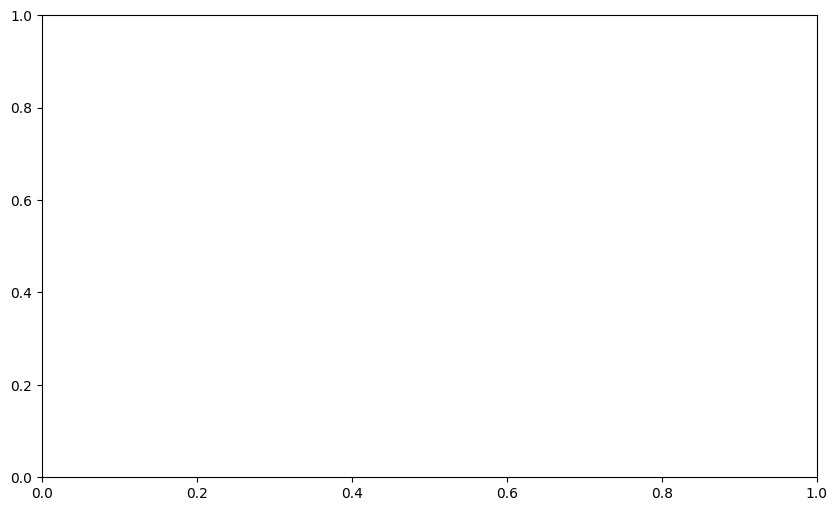

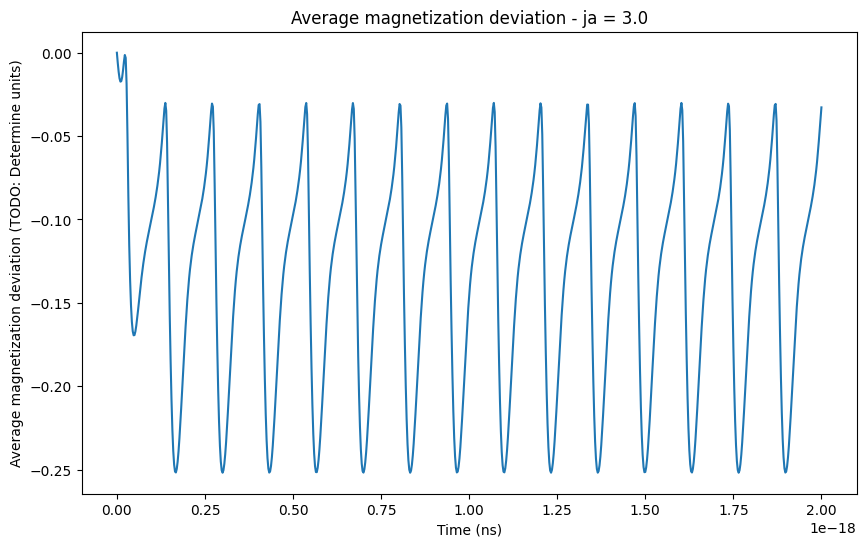

In [15]:
import matplotlib.pyplot as plt

iterated_lowest_frequencies = []

plot_output_dir = f'{iteration_dir}{os.path.sep}plots'
maxAngleFig, maxAngleAx = plt.subplots(figsize=(10, 6))  # Plot for maxAngles
 
# Read the table data from files and plot the results
for i in range(len(ja_values)):
    table_path = os.path.join(npy_dir, f'table_{i}.npy')
    table = np.load(table_path)
    table = pd.DataFrame(table, columns=["t", "mx", "my", "mz", "E_total", "maxangle"])
    dm = table["mz"] - table["mz"][0]  # average magnetization deviation
    t = table["t"]

    # Plot the Average magnetization deviation
    magFig, magAx = plt.subplots(figsize=(10, 6))  # Optional: Adjust figure size
    magAx.plot(t/1e9, dm, label='Average magnetization deviation')
    magAx.set_ylabel("Average magnetization deviation (TODO: Determine units)")
    magAx.set_xlabel("Time (ns)")
    magAx.set_title(f"Average magnetization deviation - ja = {ja_values[i]/1e12}")
    os.makedirs(plot_output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    mag_plot_filename = f"magFig_ja={ja_values[i]/1e12}.png"  # or .pdf, .svg, etc.
    mag_plot_path = os.path.join(plot_output_dir, mag_plot_filename)
    magFig.savefig(mag_plot_path)  # Save the plot to the file


    # Plot the fft spectrum
    fftFig, peak_freqs = identify_peaks_and_plot(dm, default_dt, default_fmax,ja_value = ja_values[i]/1e12)
    os.makedirs(plot_output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    fft_plot_filename = f"fftFig_ja={ja_values[i]/1e12}.png"  # or .pdf, .svg, etc.
    fft_plot_path = os.path.join(plot_output_dir, fft_plot_filename)
    fftFig.savefig(fft_plot_path)  # Save the plot to the file
    iterated_lowest_frequencies.append(peak_freqs[0]) # Save the lowest fft peak to an array for later plot

    # Plot the maxangle
    maxAngleAx.plot(table["t"], table["maxangle"], marker='o', linestyle='-', label=f'ja = {ja_values[i]/1e12}')
    maxAngleAx.set_xlabel('Time (arbitrary units)')
    maxAngleAx.set_ylabel('Max Angle (rad)')
    maxAngleAx.set_title('Max Angle Variation Over Time for All Series')
    maxAngleAx.legend(title='Series Legend')
    maxAngleAx.grid(True)

# Plot ja_values against iterated_lowest_frequencies
plt.figure(figsize=(8, 6))  # Create a figure with a custom size
skyrmionOscillationVsCurrent, skyrmionOscillationVsCurrentAx = plt.subplots(figsize=(10, 6))  # Plot for maxAngles
skyrmionOscillationVsCurrentAx.plot(ja_values/1e12, iterated_lowest_frequencies, marker='o')  # Plot with circle markers
skyrmionOscillationVsCurrentAx.set_xlabel('Ja (TA/m^2)')
skyrmionOscillationVsCurrentAx.set_ylabel('Oscillation frequency (GHz)')
skyrmionOscillationVsCurrentAx.set_title('Skyrmion oscillation frequency against spin current density')
skyrmionOscillationVsCurrentAx.grid(True)
skyrmionOscillationVsCurrent.savefig(os.path.join(plot_output_dir, "skyrmionOscillationVsCurrent.png"))

# Show the plot
maxAngleFig.savefig(os.path.join(plot_output_dir, "combined_maxangle_vs_time_colored.png"))

plt.close()